In [1]:
# @title Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
!pip install yellowbrick
!pip install prince  # Install the prince library *before* importing it
from yellowbrick.cluster import KElbowVisualizer
from prince import FAMD  # For mixed data visualization
from google.colab import files

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# @title Load the dataset
# Read the dataset
df = pd.read_csv('german_credit_data.csv', index_col=0)  # Using first column as index
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
ID,,,,,,,,,
0,67,male,skilled,own,NaN,little,1169,6,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,radio/TV
2,49,male,unskilled and resident,own,little,NaN,2096,12,education
3,45,male,skilled,free,little,little,7882,42,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,car


In [3]:
# @title Enhanced Data Preparation

# Define numerical and categorical columns
# 'Job' is moved to cat_cols as it's likely categorical
num_cols = ['Age', 'Credit amount', 'Duration']
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job']

# Ensure numerical columns are treated as numeric
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, handle errors

# Explicitly set the data type of numerical columns to numeric
# This ensures FAMD recognizes them as numerical features
for col in num_cols:
    df[col] = df[col].astype(float) #This will change the dtype to float

# Replace inf and NaN values with median for numerical features
for col in num_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan) # Replace inf with NaN
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True) # Impute NaNs with median

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(df)

# For visualization, we can use FAMD (Factor Analysis of Mixed Data)
famd = FAMD(n_components=3, random_state=42)

# Impute NaNs in both numerical and categorical features before applying FAMD
# Using SimpleImputer for consistency with the preprocessing pipeline
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df_imputed = df.copy() # Create a copy to avoid modifying the original DataFrame
# Applying imputation and ensuring correct column assignment
df_imputed[num_cols] = num_imputer.fit_transform(df_imputed[num_cols])
df_imputed[cat_cols] = cat_imputer.fit_transform(df_imputed[cat_cols])

# Now apply FAMD to the imputed DataFrame
X_famd = famd.fit_transform(df_imputed)

<ipython-input-3-ee717084a757>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True) # Impute NaNs with median



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   float64
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   object 
 3   Housing           1000 non-null   object 
 4   Saving accounts   817 non-null    object 
 5   Checking account  606 non-null    object 
 6   Credit amount     1000 non-null   float64
 7   Duration          1000 non-null   float64
 8   Purpose           1000 non-null   object 
dtypes: float64(3), object(6)
memory usage: 78.1+ KB
None

Summary Statistics:
               Age  Credit amount     Duration
count  1000.000000    1000.000000  1000.000000
mean     35.546000    3271.258000    20.903000
std      11.375469    2822.736876    12.058814
min      19.000000     250.000000     4.000000
25%      27.000000    1365.500000    12.000000
50%    

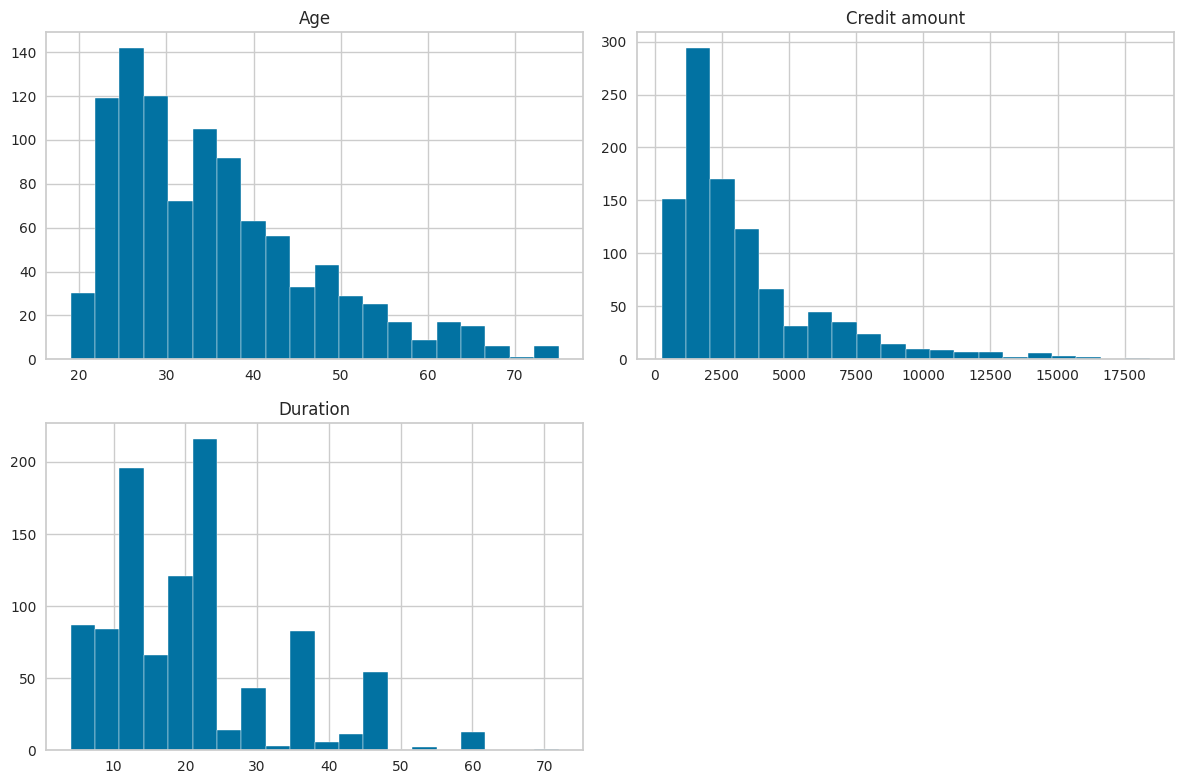

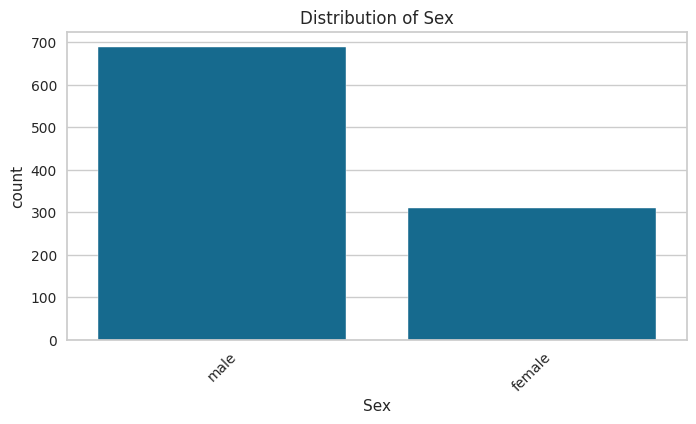

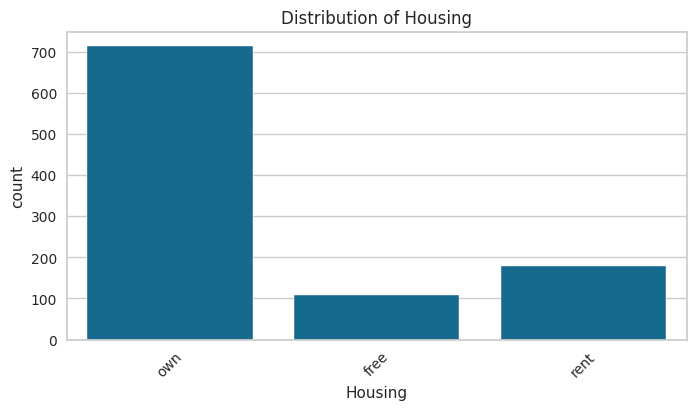

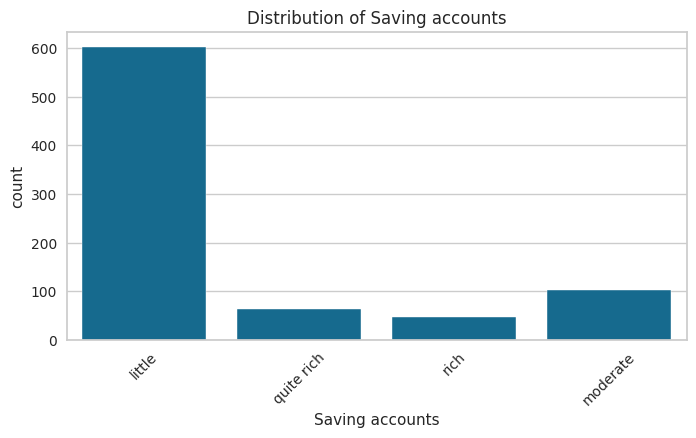

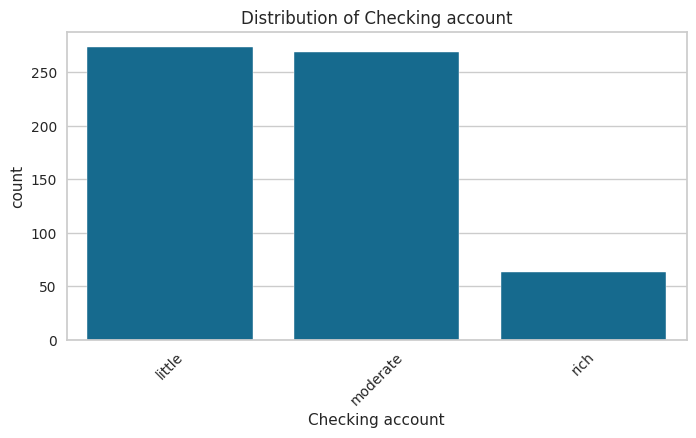

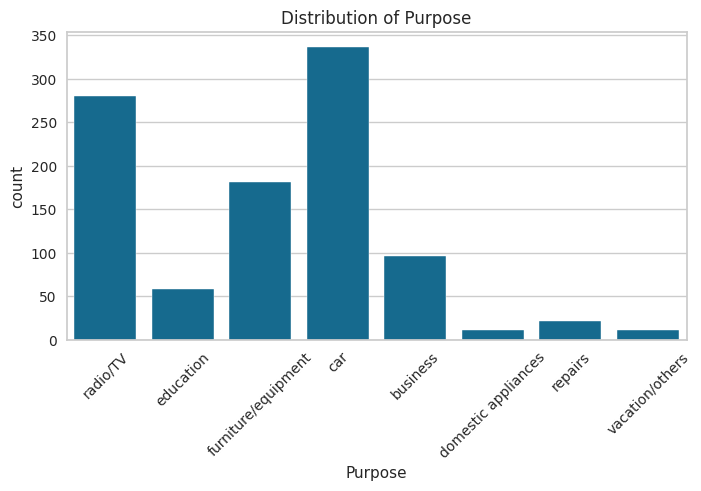

In [4]:
# @title Data Exploration
# Basic information about the dataset
print("\nDataset Info:")
print(df.info())

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize distributions of numerical features
num_cols = ['Age', 'Job', 'Credit amount', 'Duration']
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Visualize categorical features
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

Explained variance ratio: [0.27717267 0.17626867]
Total explained variance: 0.4534413399120869


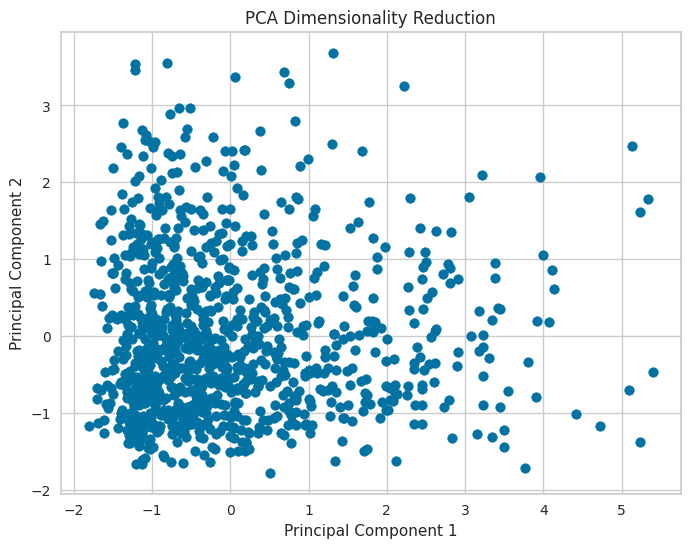

In [5]:
# @title Perform Dimensionality Reduction with PCA

import matplotlib.pyplot as plt
import numpy as np
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_pca = pca.fit_transform(X_preprocessed)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")
print(f"Total explained variance: {np.sum(explained_variance_ratio)}")

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Dimensionality Reduction")
plt.show()

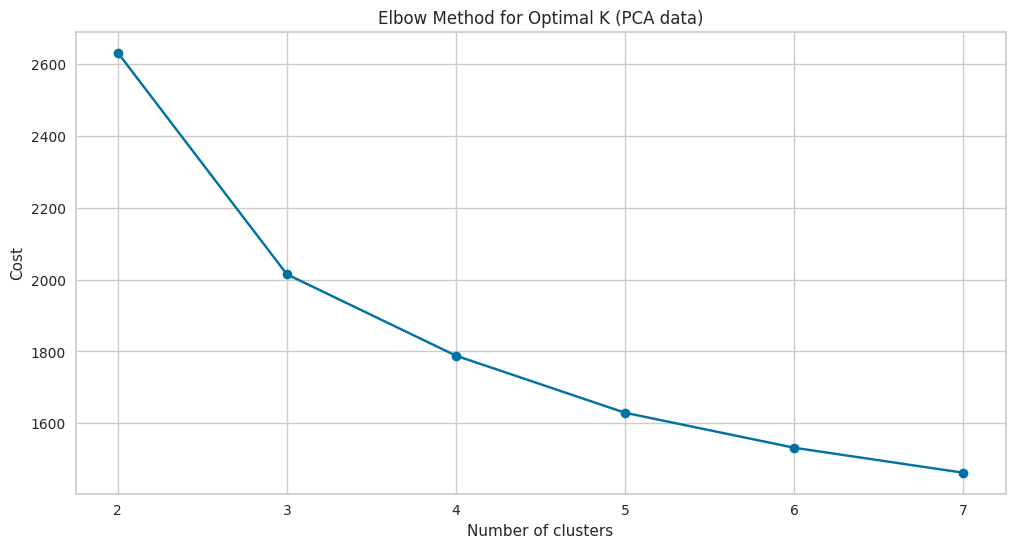

In [6]:
# @title Clustering with K-Prototypes using PCA data
# Install required package
!pip install kmodes

from kmodes.kprototypes import KPrototypes

# Assuming num_cols and cat_cols are defined earlier
num_cols_pca = ['PC1', 'PC2']  # PCA components are numerical

# Create a new DataFrame with PCA components and original categorical features
df_pca = pd.DataFrame(X_pca, columns=num_cols_pca, index=df.index)
df_pca = pd.concat([df_pca, df[cat_cols]], axis=1)

# Get indices of categorical columns in the new DataFrame
cat_indices_pca = list(range(len(num_cols_pca), df_pca.shape[1]))

# Impute missing values in categorical features of df_pca
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')  # Use most frequent for categorical features
df_pca[cat_cols] = imputer.fit_transform(df_pca[cat_cols]) # Apply imputation to only cat_cols


# Find optimal number of clusters (Elbow Method)
costs = []
for k in range(2, 8):
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    clusters = kproto.fit_predict(df_pca.values, categorical=cat_indices_pca)
    costs.append(kproto.cost_)

# Plot elbow curve
plt.plot(range(2, 8), costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K (PCA data)')
plt.show()

# Fit final model (visually k=3 is optimal based on the elbow method)
kproto = KPrototypes(n_clusters=3, init='Cao', random_state=42)
clusters_pca = kproto.fit_predict(df_pca.values, categorical=cat_indices_pca)

# Add cluster assignments to the original DataFrame
df['Cluster_PCA'] = clusters_pca

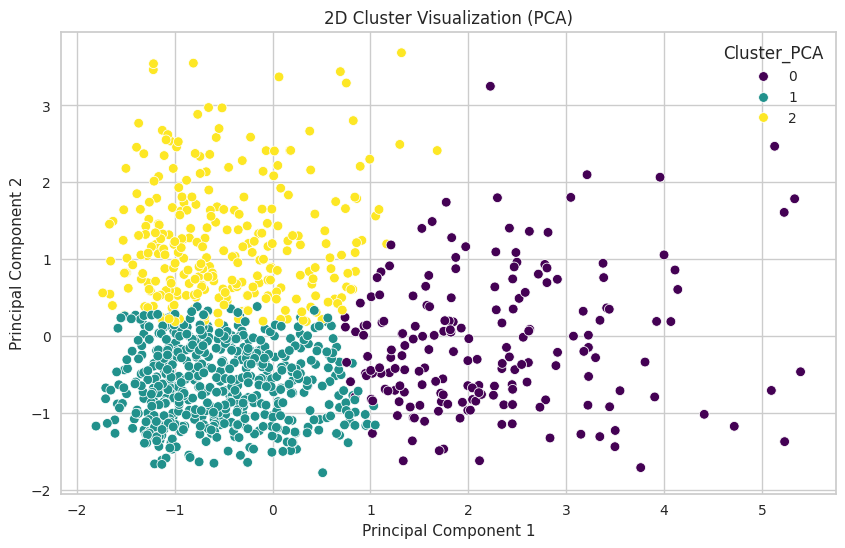

In [7]:
# @title 2D Visualization (Using PCA Data)
# 2D Visualization with PCA
plt.figure(figsize=(10, 6))
# Accessing columns by name
# The 'Cluster' column might not exist yet, we should use 'Cluster_PCA' instead.
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_PCA'], palette='viridis')
plt.title('2D Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Silhouette Score (PCA): 0.416
Davies-Bouldin Index (PCA): 0.845


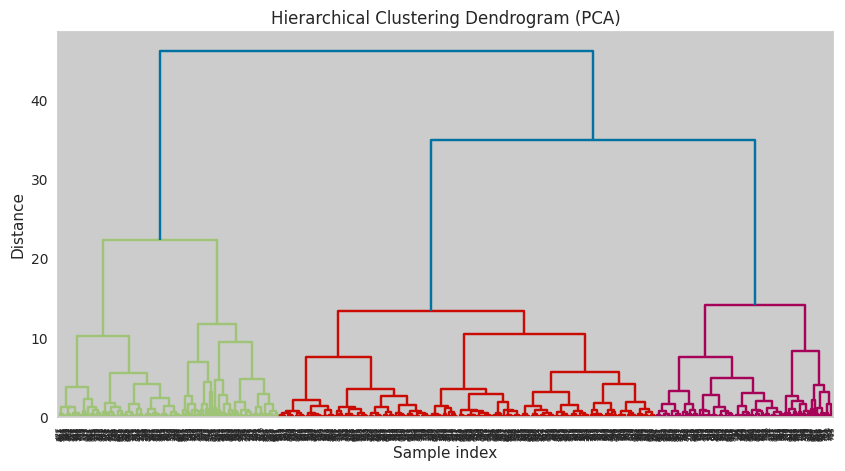


Cluster Profiles (Numerical Features, PCA):
                  PC1       PC2
Cluster_PCA                    
0            2.204565 -0.091590
1           -0.525275 -0.611256
2           -0.472435  1.224739

Sex distribution by cluster (PCA):
Sex            female      male
Cluster_PCA                    
0            0.219251  0.780749
1            0.395872  0.604128
2            0.207143  0.792857

Housing distribution by cluster (PCA):
Housing          free       own      rent
Cluster_PCA                              
0            0.229947  0.636364  0.133690
1            0.045028  0.722326  0.232645
2            0.146429  0.746429  0.107143

Saving accounts distribution by cluster (PCA):
Saving accounts    little  moderate  quite rich      rich
Cluster_PCA                                              
0                0.764286  0.164286    0.035714  0.035714
1                0.728477  0.132450    0.079470  0.059603
2                0.741071  0.089286    0.098214  0.071429

Checking a

In [8]:
# @title Cluster Evaluation and Interpretation (Using PCA Data)
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Silhouette Score (using PCA data)
silhouette_avg = silhouette_score(X_pca, df['Cluster_PCA'])  # Use X_pca and Cluster_PCA
print(f"Silhouette Score (PCA): {silhouette_avg:.3f}")

# Davies-Bouldin Index (using PCA data)
db_index = davies_bouldin_score(X_pca, df['Cluster_PCA'])  # Use X_pca and Cluster_PCA
print(f"Davies-Bouldin Index (PCA): {db_index:.3f}")

# Hierarchical clustering for dendrogram (using PCA data)
Z = linkage(X_pca, method='ward')  # Use X_pca
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (PCA)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Cluster profiles (for numerical features only, using PCA data)
# Add the 'Cluster_PCA' column to df_pca before grouping
df_pca['Cluster_PCA'] = df['Cluster_PCA']  # Add the cluster assignments to df_pca

cluster_profiles = df_pca.groupby('Cluster_PCA')[num_cols_pca].mean() #Use num_cols_pca and Cluster_PCA
print("\nCluster Profiles (Numerical Features, PCA):")
print(cluster_profiles)

# For categorical features, use a different aggregation like mode or count (using PCA data)
for col in cat_cols:
    print(f"\n{col} distribution by cluster (PCA):")
    print(pd.crosstab(df['Cluster_PCA'], df[col], normalize='index')) # Use Cluster_PCA

In [9]:
# @title Business Interpretation (Using PCA Data)
# Analyze cluster characteristics
for cluster in sorted(df['Cluster_PCA'].unique()):  # Use Cluster_PCA column
    cluster_data = df[df['Cluster_PCA'] == cluster]  # Filter by Cluster_PCA
    print(f"\nCluster {cluster} Profile (PCA Data):")  # Indicate PCA data
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(df):.1%})")

    # Numerical features (using original num_cols, not PCA components)
    print("\nNumerical Features:")
    # Exclude 'Job' from num_cols as it is not numerical
    numerical_cols = ['Age', 'Credit amount', 'Duration']
    print(cluster_data[numerical_cols].mean())

    # Categorical features
    print("\nCategorical Features:")
    for col in cat_cols:
        print(f"{col}: {cluster_data[col].mode()[0]} (most common)")

    # Potential risk assessment
    avg_credit = cluster_data['Credit amount'].mean()
    avg_age = cluster_data['Age'].mean()
    print(f"\nRisk Indicators: Avg Credit Amount: {avg_credit:.0f}, Avg Age: {avg_age:.0f}")


Cluster 0 Profile (PCA Data):
Size: 187 customers (18.7%)

Numerical Features:
Age                34.983957
Credit amount    7703.486631
Duration           38.989305
dtype: float64

Categorical Features:
Sex: male (most common)
Housing: own (most common)
Saving accounts: little (most common)
Checking account: moderate (most common)
Purpose: car (most common)

Risk Indicators: Avg Credit Amount: 7703, Avg Age: 35

Cluster 1 Profile (PCA Data):
Size: 533 customers (53.3%)

Numerical Features:
Age                28.741088
Credit amount    2178.752345
Duration           17.172608
dtype: float64

Categorical Features:
Sex: male (most common)
Housing: own (most common)
Saving accounts: little (most common)
Checking account: moderate (most common)
Purpose: radio/TV (most common)

Risk Indicators: Avg Credit Amount: 2179, Avg Age: 29

Cluster 2 Profile (PCA Data):
Size: 280 customers (28.0%)

Numerical Features:
Age                48.875
Credit amount    2390.825
Duration           15.925
dty


Cluster Means (PCA Data):
                  PC1       PC2   Sex Housing Saving accounts  \
Cluster_PCA                                                     
0            2.204565 -0.091590  male     own          little   
1           -0.525275 -0.611256  male     own          little   
2           -0.472435  1.224739  male     own          little   

            Checking account   Purpose  
Cluster_PCA                             
0                     little       car  
1                     little  radio/TV  
2                     little       car  


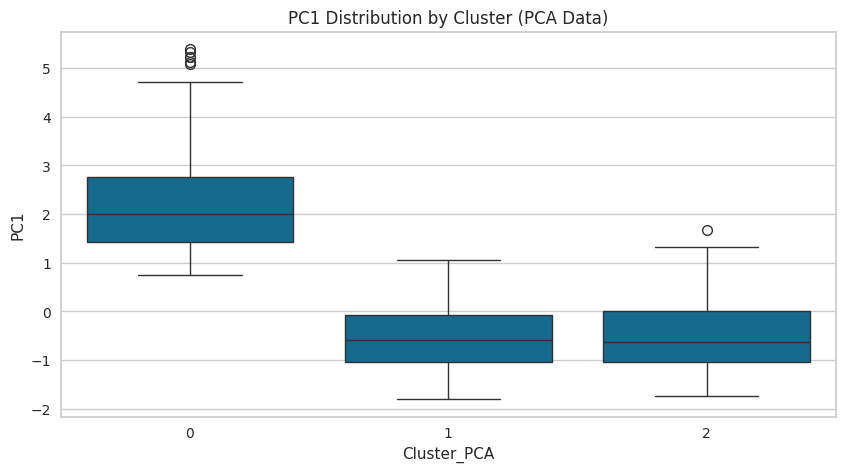

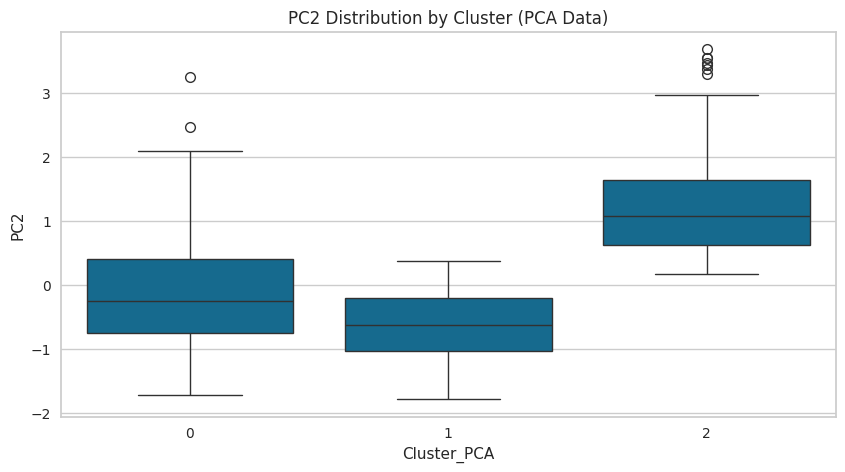

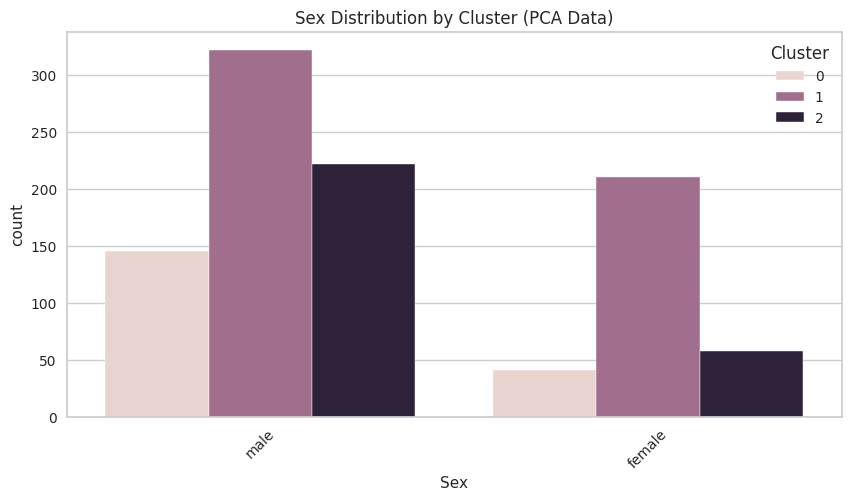

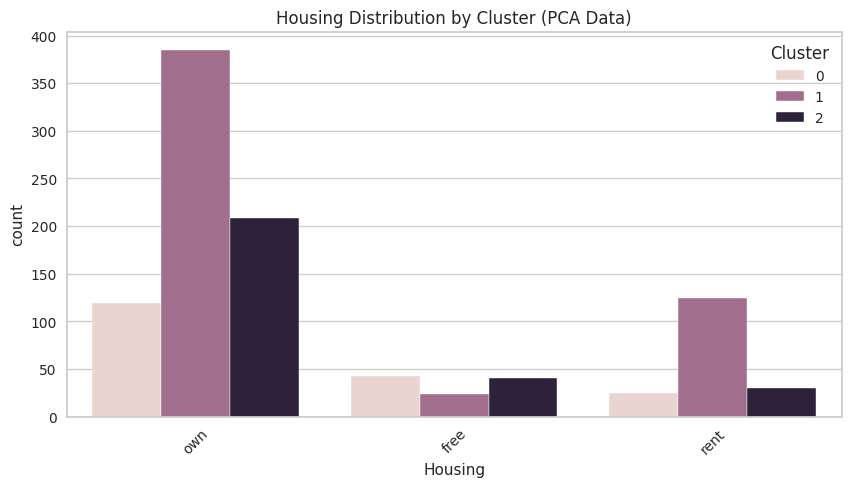

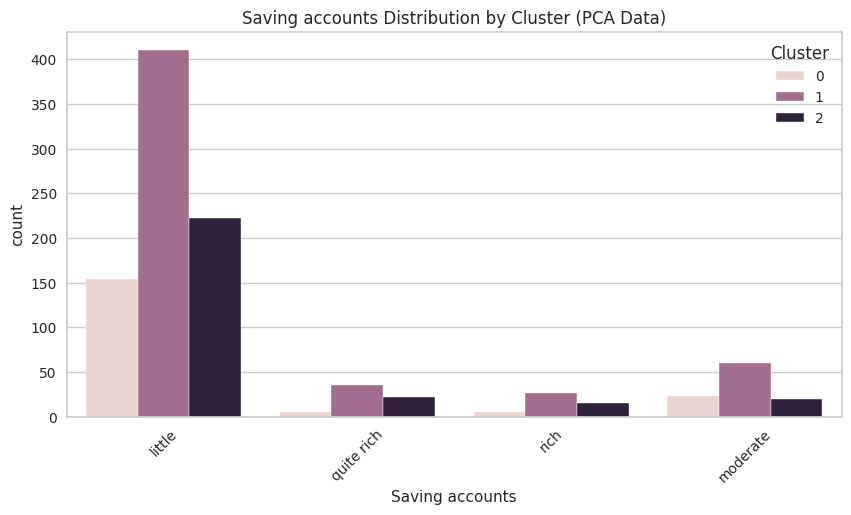

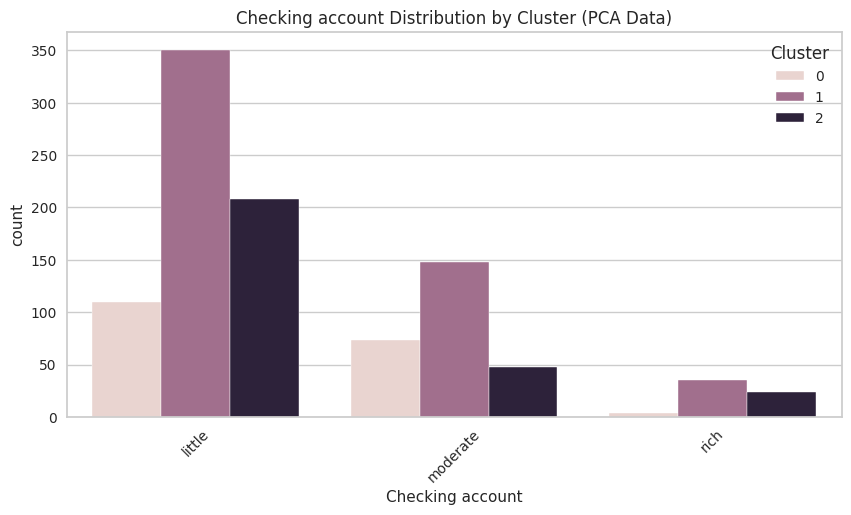

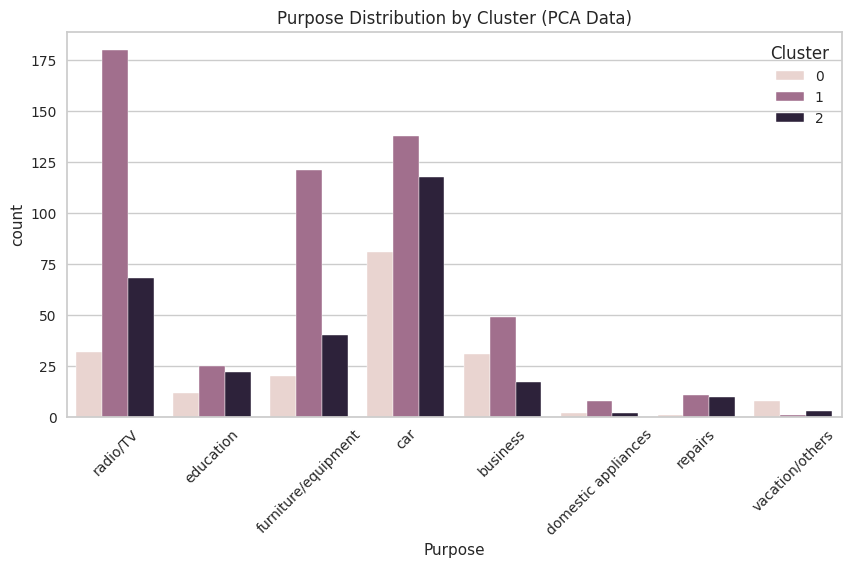

In [10]:
# @title Cluster Analysis (Using PCA Data)
# Analyze cluster characteristics
cluster_summary_pca = df_pca.groupby('Cluster_PCA').agg({
    'PC1': 'mean',
    'PC2': 'mean',
    **{col: lambda x: x.mode()[0] for col in cat_cols}  # Calculate mode for categorical columns
})  # Use df_pca and Cluster_PCA
print("\nCluster Means (PCA Data):")
print(cluster_summary_pca)

# Visualize numerical features (PCA components) by cluster
for col in num_cols_pca:  # Use num_cols_pca for PCA components
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_pca, x='Cluster_PCA', y=col)  # Use df_pca and Cluster_PCA
    plt.title(f'{col} Distribution by Cluster (PCA Data)')
    plt.show()

# Visualize categorical features by cluster (using PCA-based clusters)
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_pca, x=col, hue='Cluster_PCA')  # Use df_pca and Cluster_PCA
    plt.xticks(rotation=45)
    plt.title(f'{col} Distribution by Cluster (PCA Data)')
    plt.legend(title='Cluster')
    plt.show()

[[ 0.02314137  0.70114107  0.69039806 -0.04855237  0.04855237  0.06050405
  -0.04385631 -0.01664773  0.01304417  0.00896721 -0.01188269 -0.0101287
  -0.02902195  0.04764521 -0.01862326  0.03609749  0.03468411 -0.00521287
  -0.0057331  -0.02006012 -0.05122728 -0.00308574  0.01453752  0.08097273
  -0.01262685 -0.00399355 -0.06435233]
 [ 0.95594816  0.02699731 -0.09266652 -0.12187967  0.12187967  0.08198509
   0.01659911 -0.0985842   0.01467544 -0.0266678   0.00745902  0.00453334
   0.0393872  -0.04856577  0.00917856 -0.00366467  0.07281463 -0.00201713
   0.01313603 -0.06055316 -0.03048317  0.00582581  0.00494165  0.05945878
  -0.10243932  0.00872583  0.03425471]]
                                          PC1       PC2
num__Age                             0.023141  0.955948
num__Credit amount                   0.701141  0.026997
num__Duration                        0.690398 -0.092667
cat__Sex_female                     -0.048552 -0.121880
cat__Sex_male                        0.048552  0.1

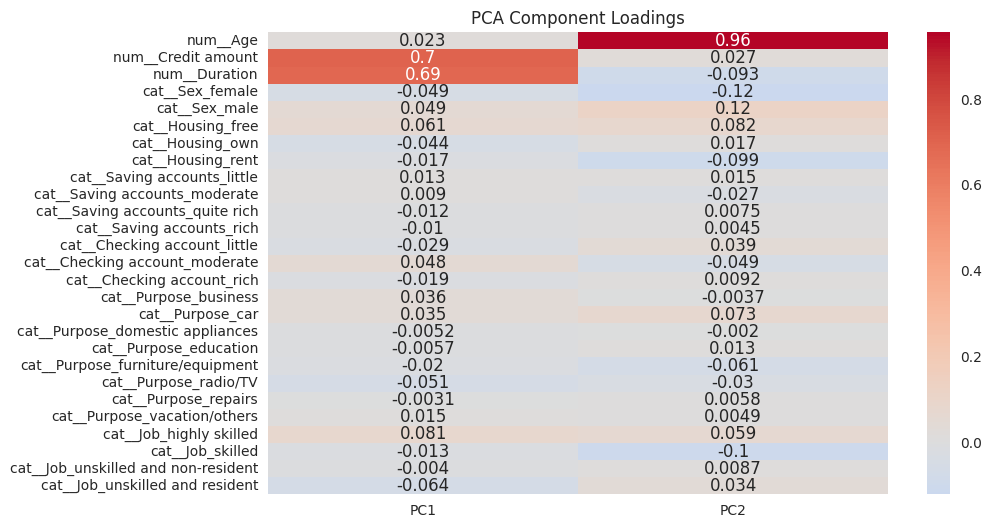

ANOVA for Age: F-statistic = 677.753, p-value = 0.000
ANOVA for Credit amount: F-statistic = 657.303, p-value = 0.000
ANOVA for Duration: F-statistic = 539.831, p-value = 0.000


In [12]:
# @title Analyze which features most influence clustering

import pandas as pd
import matplotlib.pyplot as plt
# Analyze feature influence on clustering (using PCA data)

# Feature Importance based on PCA components
# Examine the loadings of the PCA components.  The features with high absolute loadings
# on the first few principal components (especially PC1 and PC2) have the greatest influence.

# Print the PCA component loadings
print(pca.components_)

# Create a DataFrame for easier interpretation of loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=preprocessor.get_feature_names_out())
print(loadings)


# Visualize the loadings (optional)
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings')
plt.show()


# Analyze cluster profiles and compare feature means across clusters
# (already done in the previous sections)
# Focus on features that show significant differences in means or distributions across clusters.


# Statistical Tests (optional):
# Perform ANOVA or t-tests to statistically assess the differences in feature means across clusters.
# This helps determine which features have statistically significant differences between the clusters.

# Example using ANOVA (for numerical features):
from scipy.stats import f_oneway

# Exclude 'Job' from num_cols as it is not numerical
numerical_cols = ['Age', 'Credit amount', 'Duration']

for col in numerical_cols:
  groups = [df[df['Cluster_PCA'] == i][col] for i in df['Cluster_PCA'].unique()]
  f_statistic, p_value = f_oneway(*groups)
  print(f"ANOVA for {col}: F-statistic = {f_statistic:.3f}, p-value = {p_value:.3f}")

# Note: For categorical features, you could use Chi-Squared tests to assess associations.

In [13]:
# @title Stability test if clusters remain consistent across different runs.

import numpy as np
# Function to perform KPrototypes clustering and return cluster labels
def perform_clustering(df, n_clusters, random_state=42):
    # ... (Your existing data preprocessing and PCA steps) ...

    # Fit KPrototypes
    kproto = KPrototypes(n_clusters=n_clusters, init='Cao', random_state=random_state)
    clusters = kproto.fit_predict(df_pca.values, categorical=cat_indices_pca)
    return clusters

# Number of stability runs
n_runs = 5

# Store cluster labels for each run
cluster_labels_list = []

# Perform multiple runs of the clustering algorithm
for i in range(n_runs):
    clusters = perform_clustering(df, n_clusters=3, random_state=i)  # Vary random_state for different runs
    cluster_labels_list.append(clusters)

# Calculate a stability measure (e.g., Adjusted Rand Index)
from sklearn.metrics import adjusted_rand_score

stability_scores = []
for i in range(1, n_runs):
    score = adjusted_rand_score(cluster_labels_list[0], cluster_labels_list[i])
    stability_scores.append(score)
    print(f"Stability Score (Run {i+1}): {score}")

avg_stability = np.mean(stability_scores)
print(f"\nAverage Stability Score: {avg_stability}")


Stability Score (Run 2): 1.0
Stability Score (Run 3): 1.0
Stability Score (Run 4): 1.0
Stability Score (Run 5): 1.0

Average Stability Score: 1.0
